In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt

import pandas as pd
pgbs = pd.DataFrame(
    {'maturity': ['15-06-2020', '15-04-2021', '17-10-2022', '25-10-2023',
                  '15-02-2024', '15-10-2025', '21-07-2026', '14-04-2027',
                  '17-10-2028', '15-06-2029', '15-02-2030', '18-04-2034',
                  '15-04-2037', '15-02-2045'],
    'coupon': [4.8, 3.85, 2.2, 4.95,  5.65, 2.875, 2.875, 4.125,
                2.125, 1.95, 3.875, 2.25, 4.1, 4.1],
    'px': [102.532, 105.839, 107.247, 119.824, 124.005, 116.215, 117.708,
            128.027, 115.301, 114.261, 133.621, 119.879, 149.427, 159.177]})

calendar = ql.TARGET()
today = calendar.adjust(ql.Date(19, 12, 2019))
ql.Settings.instance().evaluationDate = today

bondSettlementDays = 2
bondSettlementDate = calendar.advance(
    today,
    ql.Period(bondSettlementDays, ql.Days))
frequency = ql.Annual
dc = ql.ActualActual(ql.ActualActual.ISMA)
accrualConvention = ql.ModifiedFollowing
convention = ql.ModifiedFollowing
redemption = 100.0

instruments = []
for idx, row in pgbs.iterrows():
    maturity = ql.Date(row.maturity, '%d-%m-%Y')
    schedule = ql.Schedule(
        bondSettlementDate,
        maturity,
        ql.Period(frequency),
        calendar,
        accrualConvention,
        accrualConvention,
        ql.DateGeneration.Backward,
        False)
    helper = ql.FixedRateBondHelper(
            ql.QuoteHandle(ql.SimpleQuote(row.px)),
            bondSettlementDays,
            100.0,
            schedule,
            [row.coupon / 100],
            dc,
            convention,
            redemption)

    instruments.append(helper)

params = [bondSettlementDate, instruments, dc]

cubicNots = [-30.0, -20.0, 0.0, 5.0, 10.0, 15.0,20.0, 25.0, 30.0, 40.0, 50.0]
fittingMethods = {
    'NelsonSiegelFitting': ql.NelsonSiegelFitting(),
    'SvenssonFitting': ql.SvenssonFitting(),
    'SimplePolynomialFitting': ql.SimplePolynomialFitting(2),
    'ExponentialSplinesFitting': ql.ExponentialSplinesFitting(),
    'CubicBSplinesFitting': ql.CubicBSplinesFitting(cubicNots),
}

fittedBondCurveMethods = {
    label: ql.FittedBondDiscountCurve(*params, method)
    for label, method in fittingMethods.items()
}

piecewiseMethods = {
    'logLinearDiscount': ql.PiecewiseLogLinearDiscount(*params),
    'logCubicDiscount': ql.PiecewiseLogCubicDiscount(*params),
    'linearZero': ql.PiecewiseLinearZero(*params),
    'cubicZero': ql.PiecewiseCubicZero(*params),
    'linearForward': ql.PiecewiseLinearForward(*params),
    'splineCubicDiscount': ql.PiecewiseSplineCubicDiscount(*params),
}


In [2]:
curve_LL=piecewiseMethods.get("logLinearDiscount")
curve_LL.enableExtrapolation()

curve_LZ=piecewiseMethods.get("linearZero")
curve_LZ.enableExtrapolation()

curve_LF=piecewiseMethods.get("logLinearDiscount")
curve_LF.enableExtrapolation()

curve_SC=piecewiseMethods.get("splineCubicDiscount")
curve_SC.enableExtrapolation()

In [3]:
nodes = []
start_date = ql.Date(15, 12, 2023)
while True:
    start_date += ql.Period("5Y")
    nodes.append(start_date)
    if start_date > ql.Date(30, 12, 2053):
        break

discount_factors_LL = [curve_LL.discount(d) for d in nodes]
discount_factors_LZ = [curve_LF.discount(d) for d in nodes]
discount_factors_LF = [curve_LF.discount(d) for d in nodes]
discount_factors_SC = [curve_SC.discount(d) for d in nodes]


In [4]:
display(pd.DataFrame(dict({"Date": nodes,  "Discount Factor LZ": discount_factors_LZ,"Discount Factor LL": discount_factors_LL, "Discount Factor LF": discount_factors_LF, "Discount Factor SC": discount_factors_SC})))

,Date,Discount Factor LZ,Discount Factor LL,Discount Factor LF,Discount Factor SC
0,"December 15th, 2028",0.964721,0.964721,0.964721,0.965087
1,"December 15th, 2033",0.892175,0.892175,0.892175,0.893009
2,"December 15th, 2038",0.791558,0.791558,0.791558,0.788871
3,"December 15th, 2043",0.702068,0.702068,0.702068,0.701592
4,"December 15th, 2048",0.622696,0.622696,0.622696,0.624776
5,"December 15th, 2053",0.552297,0.552297,0.552297,0.556213
6,"December 15th, 2058",0.489856,0.489856,0.489856,0.495174


In [5]:
params = [bondSettlementDate, instruments, dc]

cubicNots = [-30.0, -20.0, 0.0, 5.0, 10.0, 15.0,20.0, 25.0, 30.0, 40.0, 50.0]
fittingMethods = {
    'NelsonSiegelFitting': ql.NelsonSiegelFitting(),
    'SvenssonFitting': ql.SvenssonFitting(),
    'SimplePolynomialFitting': ql.SimplePolynomialFitting(2),
    'ExponentialSplinesFitting': ql.ExponentialSplinesFitting(),
    'CubicBSplinesFitting': ql.CubicBSplinesFitting(cubicNots),
}

fittedBondCurveMethods = {
    label: ql.FittedBondDiscountCurve(*params, method)
    for label, method in fittingMethods.items()
}

curveNS = fittedBondCurveMethods.get('NelsonSiegelFitting')
curveNS.enableExtrapolation()
curveSV = fittedBondCurveMethods.get('SvenssonFitting')
curveSV.enableExtrapolation()

In [6]:
nodes = []
start_date = ql.Date(15, 12, 2023)
while True:
    start_date += ql.Period("5Y")
    nodes.append(start_date)
    if start_date > ql.Date(30, 12, 2053):
        break

discount_factors_NS = [curveNS.discount(d) for d in nodes]
discount_factors_SV = [curveSV.discount(d) for d in nodes]

In [7]:
display(pd.DataFrame(dict({"Date": nodes,  "Discount Factor NS": discount_factors_NS,"Discount Factor SV": discount_factors_SV})))

,Date,Discount Factor NS,Discount Factor SV
0,"December 15th, 2028",0.963847,0.963848
1,"December 15th, 2033",0.887220,0.887260
2,"December 15th, 2038",0.794866,0.794887
3,"December 15th, 2043",0.702596,0.702549
4,"December 15th, 2048",0.621018,0.621070
5,"December 15th, 2053",0.556237,0.557005
6,"December 15th, 2058",0.511532,0.514419


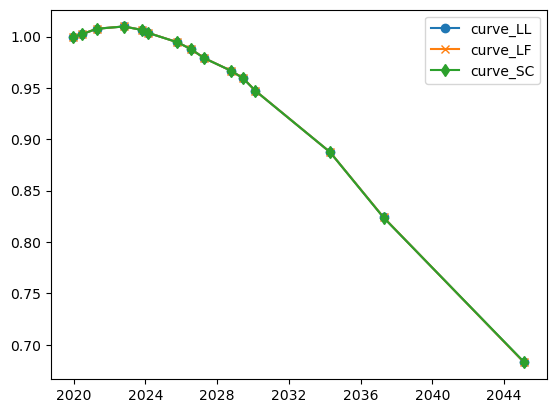

In [16]:
curve_LL.nodes()
curve_LF.nodes()
curve_SC.nodes()

plt.plot(*list(zip(*[(dt.to_date(), rate) for dt,rate in curve_LL.nodes()])), marker='o',label='curve_LL')
plt.plot(*list(zip(*[(dt.to_date(), rate) for dt,rate in curve_LF.nodes()])), marker='x',label='curve_LF',)
plt.plot(*list(zip(*[(dt.to_date(), rate) for dt,rate in curve_SC.nodes()])), marker='d',label='curve_SC')
plt.legend(['curve_LL', 'curve_LF', 'curve_SC'])

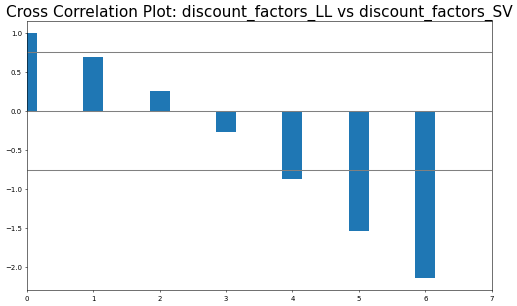

In [9]:
import statsmodels.tsa.stattools as stattools
import numpy as np


ccs = stattools.ccf(discount_factors_LL, discount_factors_SC)[:100]
nlags = len(ccs)


conf_level = 2 / np.sqrt(nlags)

plt.figure(figsize=(12,7), dpi= 50)

plt.hlines(0, xmin=0, xmax=100, color='gray')  # 0 axis
plt.hlines(conf_level, xmin=0, xmax=100, color='gray')
plt.hlines(-conf_level, xmin=0, xmax=100, color='gray')

plt.bar(x=np.arange(len(ccs)), height=ccs, width=.3)

plt.title('Cross Correlation Plot: discount_factors_LL vs discount_factors_SV', fontsize=22)
plt.xlim(0,len(ccs))
plt.show()